In [ ]:
%pip install --upgrade pandas
%pip install --upgrade numpy
%pip install --upgrade matplotlib
%pip install --upgrade seaborn
%pip install --upgrade scikit-learn-intelex
%pip install --upgrade dpcpp-cpp-rt
%pip install --upgrade xgboost
%pip install --upgrade sklearn-ex

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

# Importing Libraries

In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('all.csv')
dummies=pd.get_dummies(df[["name","datetime","preciptype","conditions","description","icon","stations"]])
core=dummies
core=df[["preciptype","temp","humidity","conditions"]].copy()





In [7]:
df.apply(pd.isnull).sum()/df.shape[0]


name                0.000000
datetime            0.000000
tempmax             0.000000
tempmin             0.000000
temp                0.000000
feelslikemax        0.000000
feelslikemin        0.000000
feelslike           0.000000
dew                 0.000000
humidity            0.000000
precip              0.000000
precipprob          0.000000
precipcover         0.000000
preciptype          0.696970
snow                0.000000
snowdepth           0.227273
windgust            0.000000
windspeed           0.000000
winddir             0.000000
sealevelpressure    0.000000
cloudcover          0.000000
visibility          0.000000
solarradiation      0.000000
solarenergy         0.000000
uvindex             0.000000
severerisk          0.000000
sunrise             0.000000
sunset              0.000000
moonphase           0.000000
conditions          0.000000
description         0.000000
icon                0.000000
stations            0.924242
dtype: float64

In [8]:
core["conditions"].value_counts()


Partially cloudy          30
Clear                     29
Overcast                   4
Rain, Partially cloudy     2
Rain                       1
Name: conditions, dtype: int64

In [9]:
core.apply(pd.isnull).sum()/df.shape[0]

preciptype    0.69697
temp          0.00000
humidity      0.00000
conditions    0.00000
dtype: float64

In [10]:
core["preciptype"]=core["preciptype"].fillna(0)
core.apply(pd.isnull).sum()/df.shape[0]

preciptype    0.0
temp          0.0
humidity      0.0
conditions    0.0
dtype: float64

<Axes: >

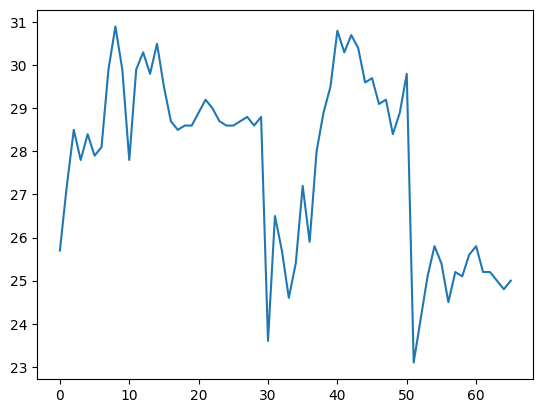

In [11]:
core["temp"].plot()


In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.size

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
df['names'].unique()

In [ ]:
df.dtypes

In [ ]:
df['names'].value_counts()

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(df.corr(),annot=True)

# defining x and y axis 

In [ ]:
y= df["preciptype"]

In [ ]:
acc = []
model = []

In [12]:
df["target"]=df.shift(-1)["temp"]

# Ensemble learning

In [13]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=.1)
predictors=df["preciptype","temp","humidity","conditions"].copy()




train = df.loc[:"05-04-2023"]
test = df.loc["22-03-2023":]
reg.fit(train[predictors],train["target"])





KeyError: ('preciptype', 'temp', 'humidity', 'conditions')

# Logistic Regression

In [ ]:

#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegression
#from sklearnex import patch_sklearn
#patch_sklearn()
#
#LogReg = LogisticRegression(random_state=2)
#
#LogReg.fit(Xtrain,Ytrain)
#
#predicted_values = LogReg.predict(Xtest)
#
#x = metrics.accuracy_score(Ytest, predicted_values)
#acc.append(x)
#model.append('Logistic Regression')
#print("Logistic Regression's Accuracy is: ", x)
#
#print(classification_report(Ytest,predicted_values))

# random forest

In [ ]:
#from sklearnex import patch_sklearn
#patch_sklearn()
#from sklearn.ensemble import RandomForestClassifier
#
#RF = RandomForestClassifier(n_estimators=20, random_state=0)
#RF.fit(Xtrain,Ytrain)
#
#predicted_values = RF.predict(Xtest)
#
#x = metrics.accuracy_score(Ytest, predicted_values)
#acc.append(x)
#model.append('RF')
#print("RF's Accuracy is: ", x)
#
#print(classification_report(Ytest,predicted_values))

# XG BOOST

In [ ]:
#from sklearnex import patch_sklearn
#patch_sklearn()
#import xgboost as xgb
#XB = xgb.XGBClassifier()
#xgb_model=XB.fit(Xtrain,Ytrain)
#
#predicted_values = XB.predict(Xtest)
#
#x = metrics.accuracy_score(Ytest, predicted_values)
#acc.append(x)
#model.append('XGBoost')
#print("XGBoost's Accuracy is: ", x)
#
#print(classification_report(Ytest,predicted_values))